In [33]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import argparse

import numpy as np
import torch
import matplotlib.pyplot as plt

from data import transformed_mnist_dataset
from data import transformed_mnist_dataset_separate
from data_utils import generated_transformed_mnist

from expert import Expert
from expert import AffineExpert
from expert import TranslationExpert
from expert import ConvolutionExpert
from discriminator import Discriminator
from discriminator import ConvolutionDiscriminator
from discriminator import MechanismConvolutionDiscriminator
from sequence_icm import SequenceICM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# generated_transformed_mnist(
#     './datasets', num_transform=1, num_copy_per_image=5, add_rotation=False
# )

In [3]:
args = argparse.Namespace()
args.num_experts = 5
args.input_shape = [28, 28, 1]
args.d_output_size = 1
args.num_epoch = 20
args.min_init_loss = 0.01
args.num_initialize_epoch = 10
args.batch_size = 80
args.cuda = torch.cuda.is_available()
args.num_transform = 2

args.width_multiplier = 2
args.use_sn = False
args.discriminator_sigmoid = True

args.device = torch.device("cuda" if args.cuda else "cpu")

In [4]:
original_dataloader, transformed_dataloader = transformed_mnist_dataset_separate(args.batch_size, args)

transformed data number: 300000
original data number: 60000
multiple: 2
torch.Size([60000, 1, 28, 28]) torch.Size([300000, 1, 28, 28])


In [20]:
class DataSampler:
    """Infinite sampling."""
    def __init__(self, original_dataloader, transformed_dataloader):
        super(DataSampler, self).__init__()
        self.original_dataloader = original_dataloader
        self.transformed_dataloader = transformed_dataloader
        self.original_iter = iter(self.original_dataloader)
        self.transformed_iter = iter(self.transformed_dataloader)

    def get_batch(self):
        try:
            original_batch = self.original_iter.next()
        except StopIteration:
            self.original_iter = iter(self.original_dataloader)
            original_batch = self.original_iter.next()
        try:
            transformed_batch = self.transformed_iter.next()
        except StopIteration:
            self.transformed_iter = iter(self.transformed_dataloader)
            transformed_batch = self.transformed_iter.next()
        batch = torch.cat((original_batch[0], transformed_batch[0]), axis=0)
        shuffle_idx = torch.randperm(batch.shape[0])
        return batch[shuffle_idx]

    def reset(self):
        self.original_iter = iter(self.original_dataloader)
        self.transformed_iter = iter(self.transformed_dataloader)

In [21]:
sampler = DataSampler(original_dataloader, transformed_dataloader)

In [22]:
batch = sampler.get_batch()

In [8]:
batch.shape

torch.Size([160, 1, 28, 28])

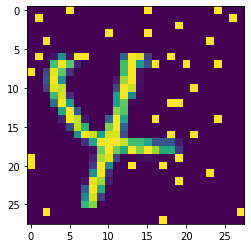

In [9]:
plt.imshow(batch[-1].numpy()[0])

In [23]:
# Model
mechaisms = [ConvolutionExpert(args).to(args.device) for i in range(args.num_experts)]
data_discriminator = ConvolutionDiscriminator(args).to(args.device)
mech_discriminator = MechanismConvolutionDiscriminator(args).to(args.device)

In [24]:
learner = SequenceICM(mechaisms, data_discriminator, mech_discriminator, args)

In [25]:
batch = sampler.get_batch()

In [26]:
stats = learner.train(batch)

In [27]:
stats

{'fake discriminator loss': 0.4774491488933563,
 'disentangle loss': 1.612091064453125,
 'real discriminator loss': 0.4744367301464081}

In [28]:
all_stats = []
for i in range(10000):
    batch = sampler.get_batch()
    stats = learner.train(batch)
    all_stats.append(stats)
    if i % 200 == 0:
        print('=============={}=============='.format(i))
        print('fake d loss       {:.6f}'.format(stats['fake discriminator loss']))
        print('disentangle loss  {:.6f}'.format(stats['disentangle loss']))
        print('real d loss       {:.6f}'.format(stats['real discriminator loss']))

==============0==============
fake d loss       0.474535
disentangle loss  1.612037
real d loss       0.471914
==============200==============
fake d loss       0.693147
disentangle loss  1.611901
real d loss       0.693147
==============400==============
fake d loss       0.693147
disentangle loss  1.611908
real d loss       0.693147
==============600==============
fake d loss       0.693147
disentangle loss  1.611911
real d loss       0.693147
==============800==============
fake d loss       0.693147
disentangle loss  1.611906
real d loss       0.693147
==============1000==============
fake d loss       0.693147
disentangle loss  1.611908
real d loss       0.693147
==============1200==============
fake d loss       0.693147
disentangle loss  1.611906
real d loss       0.693147
==============1400==============
fake d loss       0.693147
disentangle loss  1.611902
real d loss       0.693147
==============1600==============
fake d loss       0.693147
disentangle loss  1.611899
real d l

KeyboardInterrupt: 

In [29]:
batch = sampler.get_batch()

In [30]:
out = [m(batch.to('cuda')).detach().cpu().numpy() for m in mechaisms]

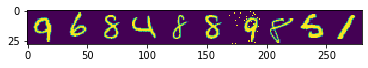

In [31]:
batch_np = batch.detach().numpy()
batch_subset = batch_np[-10:].reshape((10, 28, 28))
batch_subset = np.concatenate(batch_subset, axis=1)
plt.imshow(batch_subset)

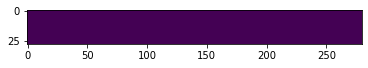

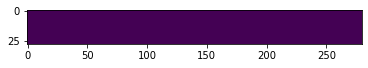

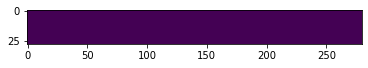

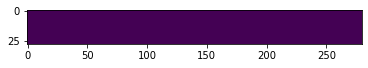

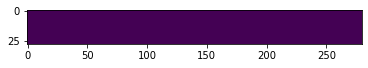

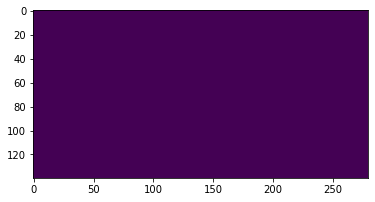

In [32]:
final_out = []
for o in out:
    o_ = o[-10:].reshape((10, 28, 28))
    o_ = np.concatenate(o_, axis=1)
    final_out.append(o_)
    plt.imshow(o_)
    plt.show()
plt.imshow(np.concatenate(final_out,axis=0))
plt.show()

In [53]:
batch_np.max()

1.0

In [60]:
final_out[1].max()

0.0007508472

# unrelated stuff

In [109]:
def get_frozen_state_dict(model):
    state_dict = model.state_dict()
    for param_tensor in state_dict:
        values = state_dict[param_tensor]
        state_dict[param_tensor] = values.clone().detach()
    return state_dict

def get_frozen_parameter_dict(model):
    state_dict = {}
    for param_tensor in model.parameters():
        print(type(param_tensor))
        values = param_tensor.clone().detach()
        state_dict[param_tensor] = values
    return state_dict

def get_gaussian_perturb(model, scale):
    state_dict = get_frozen_state_dict(model)
    for n, p in model.named_parameters():
        param_val = p.detach().numpy()
        param_val += np.random.normal(size=param_val.shape)*scale
        state_dict[n] = torch.from_numpy(param_val)
    return state_dict

In [110]:
model = torch.nn.Linear(10, 10)
state_dict_1 = get_frozen_state_dict(model)
parameter_1 = get_frozen_parameter_dict(model)

<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


In [111]:
# for n, p in model.named_parameters():
#     print(n)
#     if n in state_dict_1:
#         print(p.detach().numpy())
d = get_gaussian_perturb(model, 0.1)
model.load_state_dict(d)

<All keys matched successfully>

In [112]:
x = torch.from_numpy(np.random.normal(size=(2, 10))).float()

In [113]:
y = model(x)

In [114]:
loss = torch.norm(y)
loss

tensor(0., grad_fn=<CopyBackwards>)

In [91]:
optimizer = torch.optim.Adam(model.parameters())

In [92]:
model.zero_grad()
loss.backward()

In [93]:
optimizer.step()

In [94]:
state_dict_2 = model.state_dict()
parameter_2 = model.parameters()

In [95]:
state_dict_1

OrderedDict([('weight',
              tensor([[-1.3196e-01, -5.1824e-02,  1.3071e-01,  5.3954e-02, -7.0111e-02,
                        1.7568e-01, -1.6684e-01,  2.6674e-01,  1.0355e-01,  2.5488e-02],
                      [ 9.2583e-02,  5.4285e-02, -2.1570e-01, -8.4548e-02,  1.2645e-01,
                       -4.3467e-02,  1.9493e-01,  1.0550e-01, -1.5481e-01,  1.9082e-01],
                      [ 7.1191e-03, -2.8275e-01, -3.0609e-01, -1.2482e-01, -2.4284e-01,
                        1.3349e-01, -2.0959e-01,  2.7206e-01, -2.3598e-01,  2.2769e-01],
                      [ 1.3802e-01, -3.0904e-01, -7.7796e-02,  3.0627e-01,  1.7139e-01,
                       -2.8944e-01, -2.3291e-01, -3.3122e-03, -2.3925e-01, -2.7723e-01],
                      [ 1.7105e-01,  1.2039e-01, -2.6887e-01,  2.8853e-01, -2.1069e-01,
                       -1.6866e-01,  6.2086e-02,  2.9987e-02, -2.6222e-01, -1.0765e-01],
                      [-5.8090e-03,  4.1492e-02,  3.2596e-02,  8.7823e-03, -6.8755e-02,
   

In [96]:
state_dict_2

OrderedDict([('weight',
              tensor([[-0.1310, -0.0508,  0.1317,  0.0530, -0.0691,  0.1747, -0.1678,  0.2657,
                        0.1045,  0.0245],
                      [ 0.0936,  0.0553, -0.2147, -0.0855,  0.1274, -0.0445,  0.1939,  0.1045,
                       -0.1538,  0.1898],
                      [ 0.0081, -0.2817, -0.3051, -0.1258, -0.2418,  0.1325, -0.2106,  0.2711,
                       -0.2350,  0.2267],
                      [ 0.1370, -0.3100, -0.0788,  0.3073,  0.1704, -0.2884, -0.2319, -0.0023,
                       -0.2403, -0.2762],
                      [ 0.1720,  0.1214, -0.2679,  0.2875, -0.2097, -0.1697,  0.0611,  0.0290,
                       -0.2632, -0.1087],
                      [-0.0048,  0.0425,  0.0336,  0.0078, -0.0678, -0.2563,  0.2779,  0.1069,
                       -0.1253,  0.0582],
                      [-0.1465,  0.1585,  0.0735, -0.1263,  0.0367, -0.0709, -0.0677, -0.2978,
                        0.1381,  0.2172],
                 

In [97]:
parameter_1.keys()

dict_keys([Parameter containing:
tensor([[-0.1310, -0.0508,  0.1317,  0.0530, -0.0691,  0.1747, -0.1678,  0.2657,
          0.1045,  0.0245],
        [ 0.0936,  0.0553, -0.2147, -0.0855,  0.1274, -0.0445,  0.1939,  0.1045,
         -0.1538,  0.1898],
        [ 0.0081, -0.2817, -0.3051, -0.1258, -0.2418,  0.1325, -0.2106,  0.2711,
         -0.2350,  0.2267],
        [ 0.1370, -0.3100, -0.0788,  0.3073,  0.1704, -0.2884, -0.2319, -0.0023,
         -0.2403, -0.2762],
        [ 0.1720,  0.1214, -0.2679,  0.2875, -0.2097, -0.1697,  0.0611,  0.0290,
         -0.2632, -0.1087],
        [-0.0048,  0.0425,  0.0336,  0.0078, -0.0678, -0.2563,  0.2779,  0.1069,
         -0.1253,  0.0582],
        [-0.1465,  0.1585,  0.0735, -0.1263,  0.0367, -0.0709, -0.0677, -0.2978,
          0.1381,  0.2172],
        [ 0.0067, -0.1692, -0.0010,  0.0308, -0.2487, -0.1092, -0.2094, -0.0748,
          0.1213,  0.0544],
        [ 0.0981, -0.1467, -0.0940,  0.2579, -0.1289, -0.3071,  0.2435, -0.1268,
         -0.21

In [98]:
list(parameter_2)

[Parameter containing:
 tensor([[-0.1310, -0.0508,  0.1317,  0.0530, -0.0691,  0.1747, -0.1678,  0.2657,
           0.1045,  0.0245],
         [ 0.0936,  0.0553, -0.2147, -0.0855,  0.1274, -0.0445,  0.1939,  0.1045,
          -0.1538,  0.1898],
         [ 0.0081, -0.2817, -0.3051, -0.1258, -0.2418,  0.1325, -0.2106,  0.2711,
          -0.2350,  0.2267],
         [ 0.1370, -0.3100, -0.0788,  0.3073,  0.1704, -0.2884, -0.2319, -0.0023,
          -0.2403, -0.2762],
         [ 0.1720,  0.1214, -0.2679,  0.2875, -0.2097, -0.1697,  0.0611,  0.0290,
          -0.2632, -0.1087],
         [-0.0048,  0.0425,  0.0336,  0.0078, -0.0678, -0.2563,  0.2779,  0.1069,
          -0.1253,  0.0582],
         [-0.1465,  0.1585,  0.0735, -0.1263,  0.0367, -0.0709, -0.0677, -0.2978,
           0.1381,  0.2172],
         [ 0.0067, -0.1692, -0.0010,  0.0308, -0.2487, -0.1092, -0.2094, -0.0748,
           0.1213,  0.0544],
         [ 0.0981, -0.1467, -0.0940,  0.2579, -0.1289, -0.3071,  0.2435, -0.1268,
       